In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Metal device set to: Apple M1 Pro


2022-05-26 00:43:14.302833: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-26 00:43:14.303188: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


True

In [2]:
data_dir1 = 'driver_detection/imgs/train'
data_dir = pathlib.Path(data_dir1)

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

22424


In [3]:
batch_size = 64
img_width = 200
img_height = int(img_width/640*480)
print(img_height)
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="training",
  seed=123,
  shuffle=True,
  image_size=(img_height, img_width),
  batch_size=batch_size)
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  seed=123,
  shuffle=True,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)
class_names = train_ds.class_names
print(class_names)

150
Found 22424 files belonging to 8 classes.
Using 15697 files for training.


2022-05-26 00:43:17.573796: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-26 00:43:17.573840: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 22424 files belonging to 8 classes.
Using 6727 files for validation.
['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']
['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']


2022-05-26 00:43:19.666248: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


(64, 150, 200, 3)
(64,)


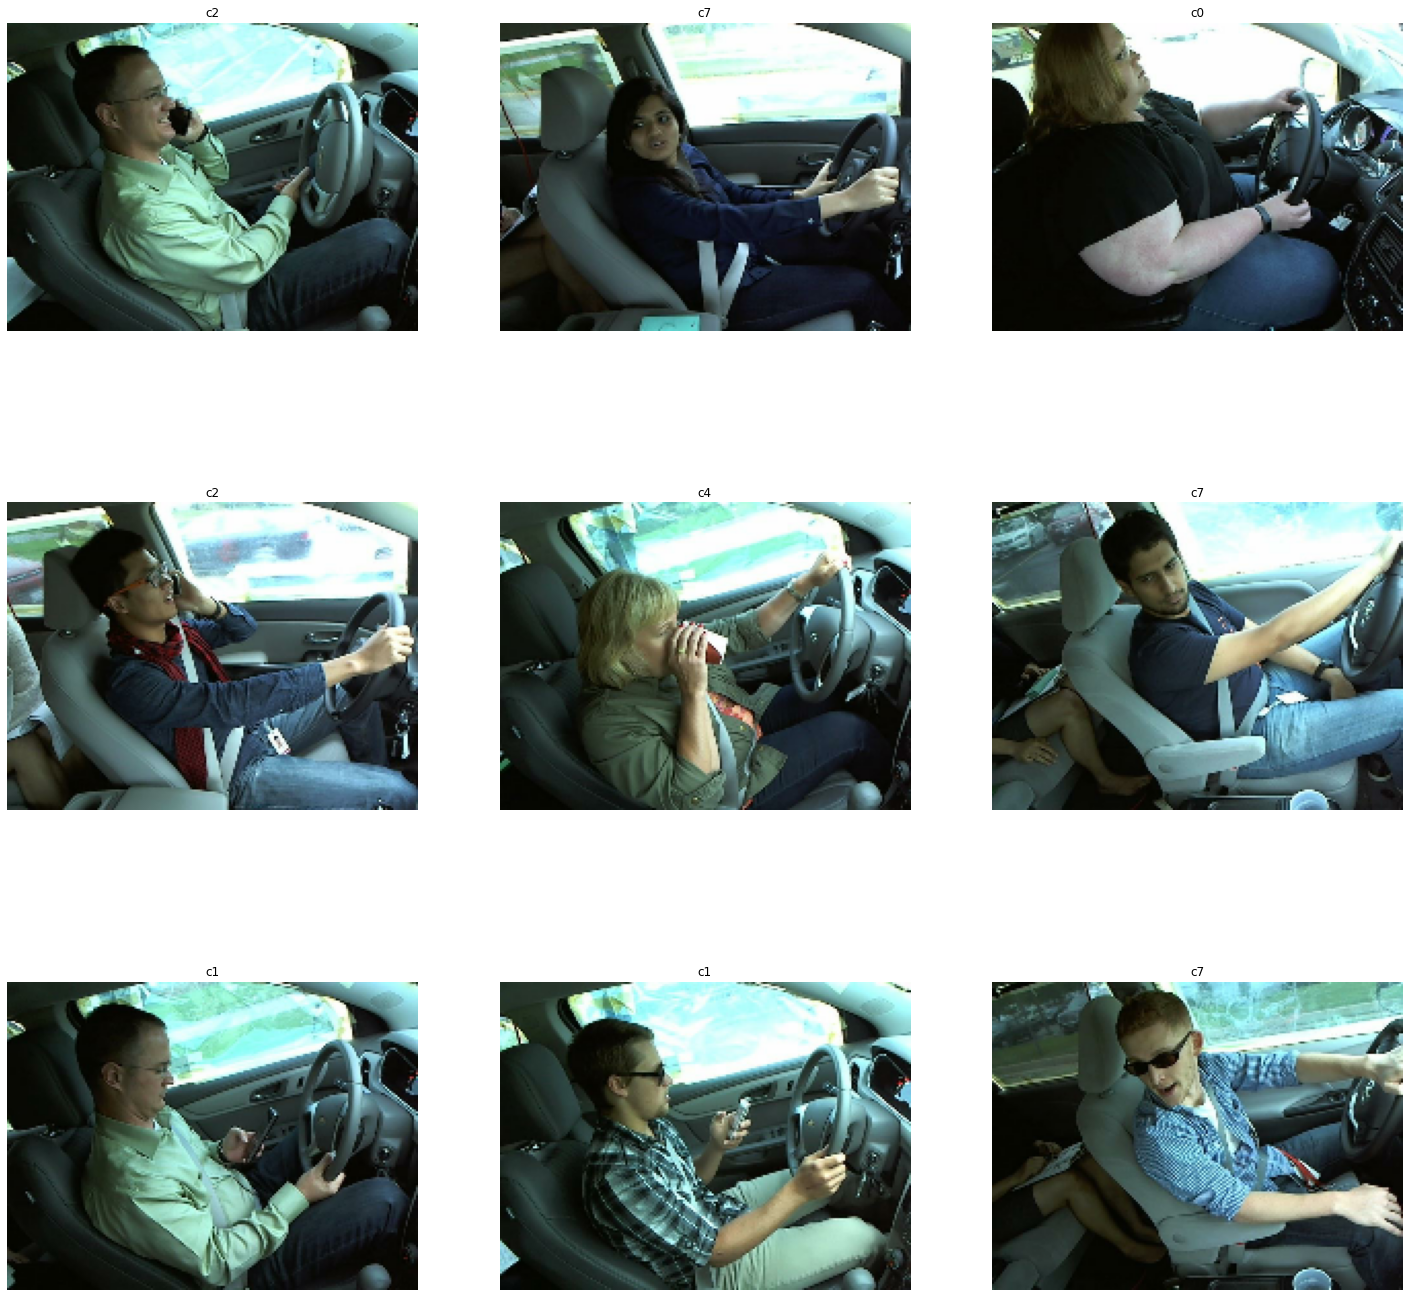

In [4]:
plt.figure(figsize=(25, 25))
for images, labels in train_ds.take(3):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

In [5]:
with tf.device('/cpu:0'):
    img_augmentation = Sequential(
        [
            layers.RandomTranslation(height_factor=0.1, width_factor=(0,0.1), input_shape=(img_height, img_width, 3)),
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(factor=0.1),
            layers.RandomZoom(-0.2, 0.1),
            layers.RandomContrast(factor=(0.2,0)),],name="img_augmentation",
    )

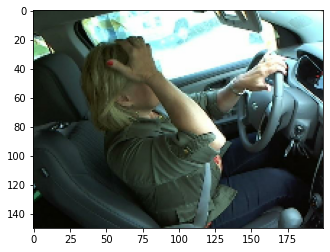

In [10]:
plt.imshow(image[0].numpy().astype("uint8"))

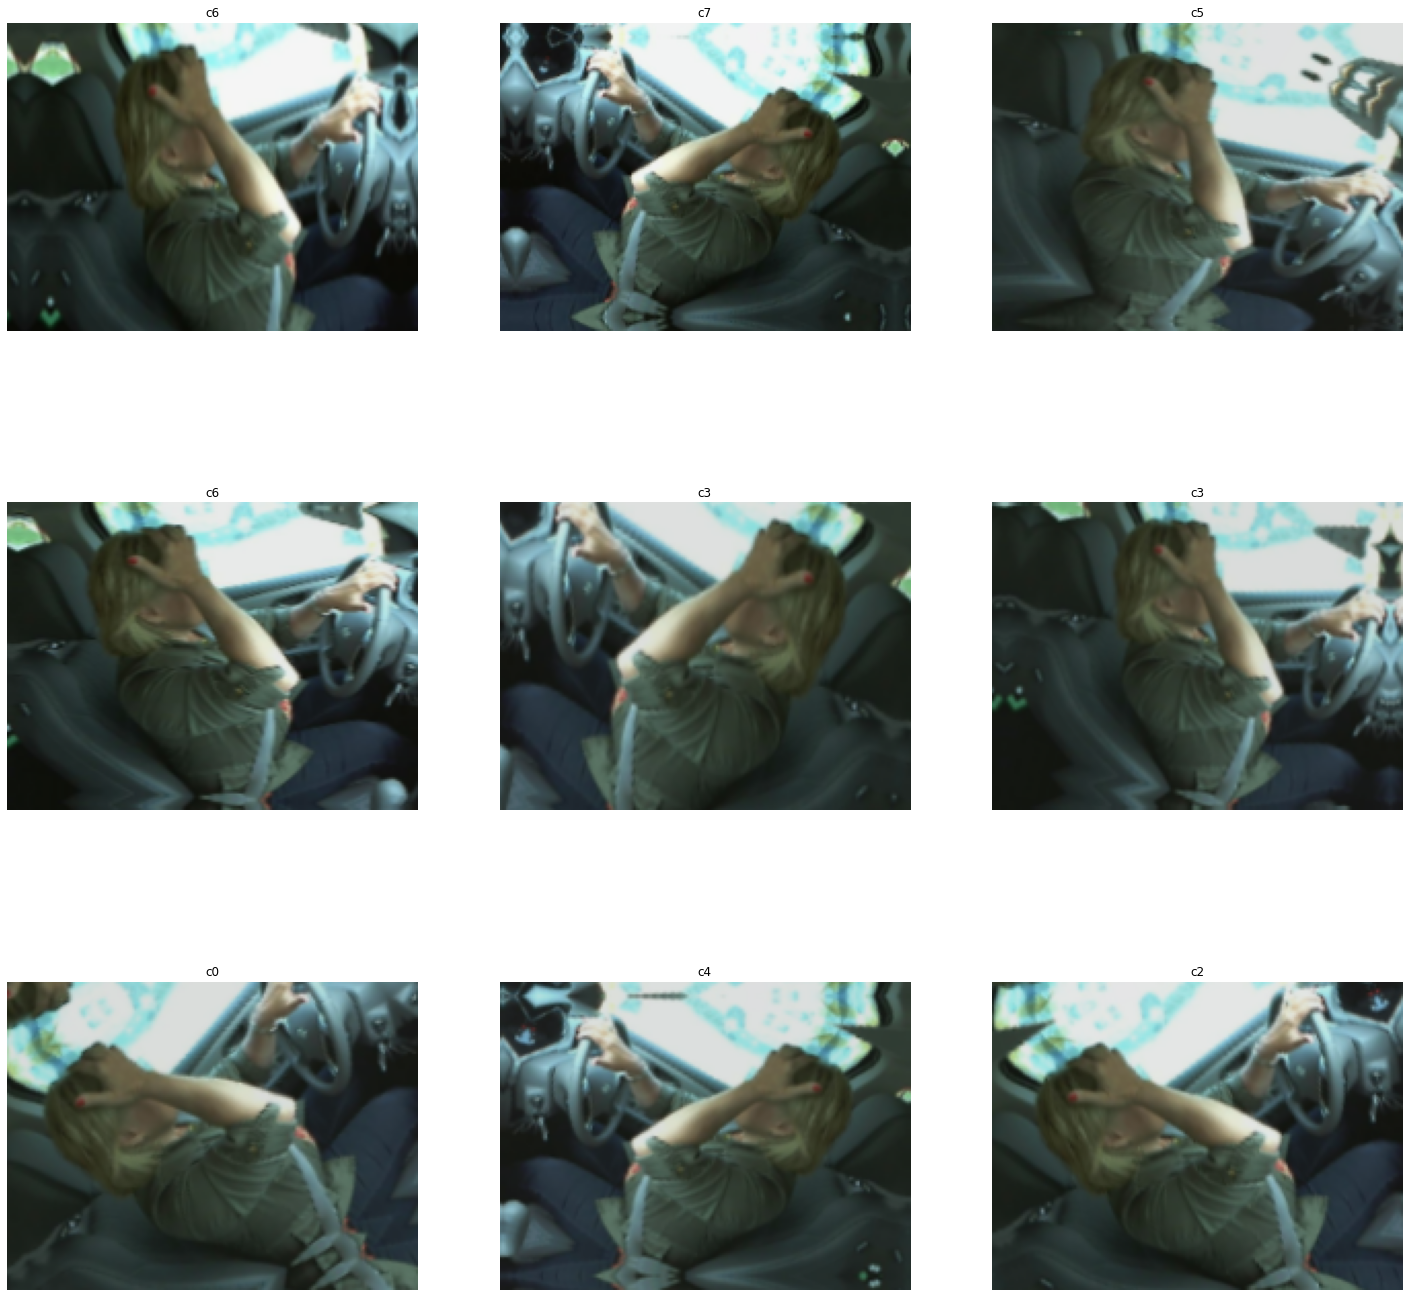

In [6]:
plt.figure(figsize=(25, 25))
for image, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(tf.expand_dims(image[0], axis=0))
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(100).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
num_classes = len(class_names)

model = Sequential([

    img_augmentation,
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    
    layers.Conv2D(16, 3, padding='same'),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(32, 3, padding='same'),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64, 3, padding='same'),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['sparse_categorical_accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img_augmentation (Sequentia  (None, 150, 200, 3)      0         
 l)                                                              
                                                                 
 rescaling (Rescaling)       (None, 150, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 150, 200, 16)      448       
                                                                 
 activation (Activation)     (None, 150, 200, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 100, 16)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 100, 32)       4

In [9]:
epochs=100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/100


2022-05-17 20:15:50.277978: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


246/246 [==============================] - ETA: 0s - loss: 1.9865 - sparse_categorical_accuracy: 0.2311

2022-05-17 20:16:24.150006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


246/246 [==============================] - 37s 135ms/step - loss: 1.9865 - sparse_categorical_accuracy: 0.2311 - val_loss: 1.8870 - val_sparse_categorical_accuracy: 0.2982
Epoch 2/100
246/246 [==============================] - 45s 182ms/step - loss: 1.6401 - sparse_categorical_accuracy: 0.3910 - val_loss: 1.3315 - val_sparse_categorical_accuracy: 0.5148
Epoch 3/100
246/246 [==============================] - 47s 189ms/step - loss: 1.2649 - sparse_categorical_accuracy: 0.5450 - val_loss: 1.0843 - val_sparse_categorical_accuracy: 0.6144
Epoch 4/100
246/246 [==============================] - 47s 192ms/step - loss: 0.9834 - sparse_categorical_accuracy: 0.6559 - val_loss: 1.0992 - val_sparse_categorical_accuracy: 0.6499
Epoch 5/100
246/246 [==============================] - 48s 194ms/step - loss: 0.7954 - sparse_categorical_accuracy: 0.7275 - val_loss: 0.7366 - val_sparse_categorical_accuracy: 0.7635
Epoch 6/100
246/246 [==============================] - 46s 189ms/step - loss: 0.6813 - spars

246/246 [==============================] - 30s 121ms/step - loss: 0.0983 - sparse_categorical_accuracy: 0.9684 - val_loss: 0.1952 - val_sparse_categorical_accuracy: 0.9448
Epoch 90/100
246/246 [==============================] - 31s 127ms/step - loss: 0.0993 - sparse_categorical_accuracy: 0.9695 - val_loss: 0.2035 - val_sparse_categorical_accuracy: 0.9440
Epoch 91/100
246/246 [==============================] - 30s 123ms/step - loss: 0.0947 - sparse_categorical_accuracy: 0.9699 - val_loss: 0.2030 - val_sparse_categorical_accuracy: 0.9437
Epoch 92/100
246/246 [==============================] - 30s 121ms/step - loss: 0.0972 - sparse_categorical_accuracy: 0.9677 - val_loss: 0.1977 - val_sparse_categorical_accuracy: 0.9443
Epoch 93/100
246/246 [==============================] - 27s 109ms/step - loss: 0.0999 - sparse_categorical_accuracy: 0.9663 - val_loss: 0.1782 - val_sparse_categorical_accuracy: 0.9477
Epoch 94/100
246/246 [==============================] - 27s 109ms/step - loss: 0.1010 - 

In [10]:
model.save('test1.h5')

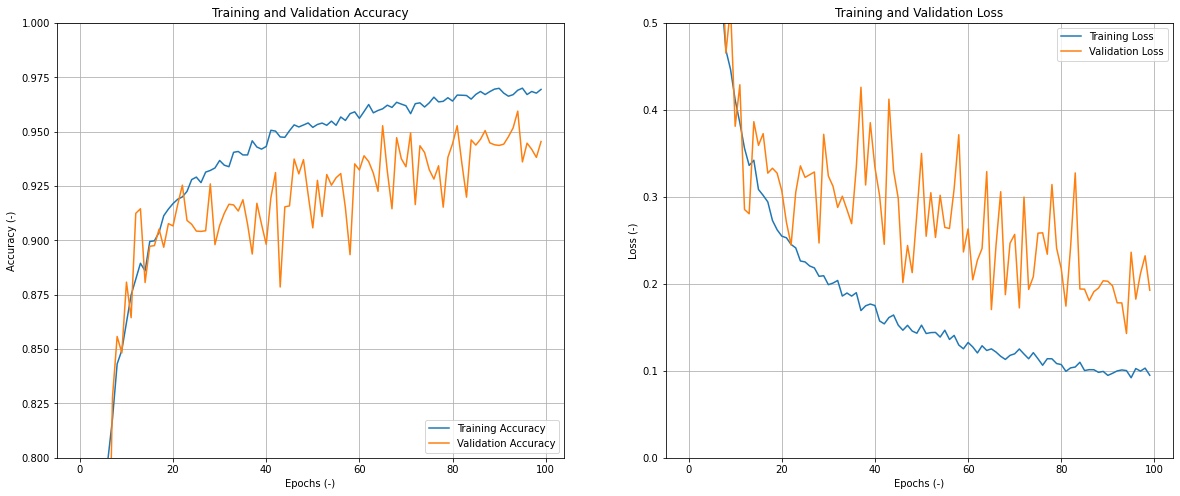

In [11]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim((0.8,1))
plt.grid(True)
plt.xlabel("Epochs (-)")
plt.ylabel("Accuracy (-)")
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylim((0.0,0.5))
plt.grid(True)
plt.xlabel("Epochs (-)")
plt.ylabel("Loss (-)")
plt.title('Training and Validation Loss')
plt.show()

tf.Tensor(
[[ 671    8    1    1    0    0    3   14]
 [  13 1360    4    1    3    0    2    1]
 [  28   10 1327    2    3    0   11    2]
 [   6    0    2  661    0    0    0    0]
 [   0    5   28    0  657    0   33    1]
 [   3    0    9   19    0  579   10   11]
 [  11    6   16    2    8    1  529   11]
 [  59    0    5    3    2    0    9  576]], shape=(8, 8), dtype=int32)


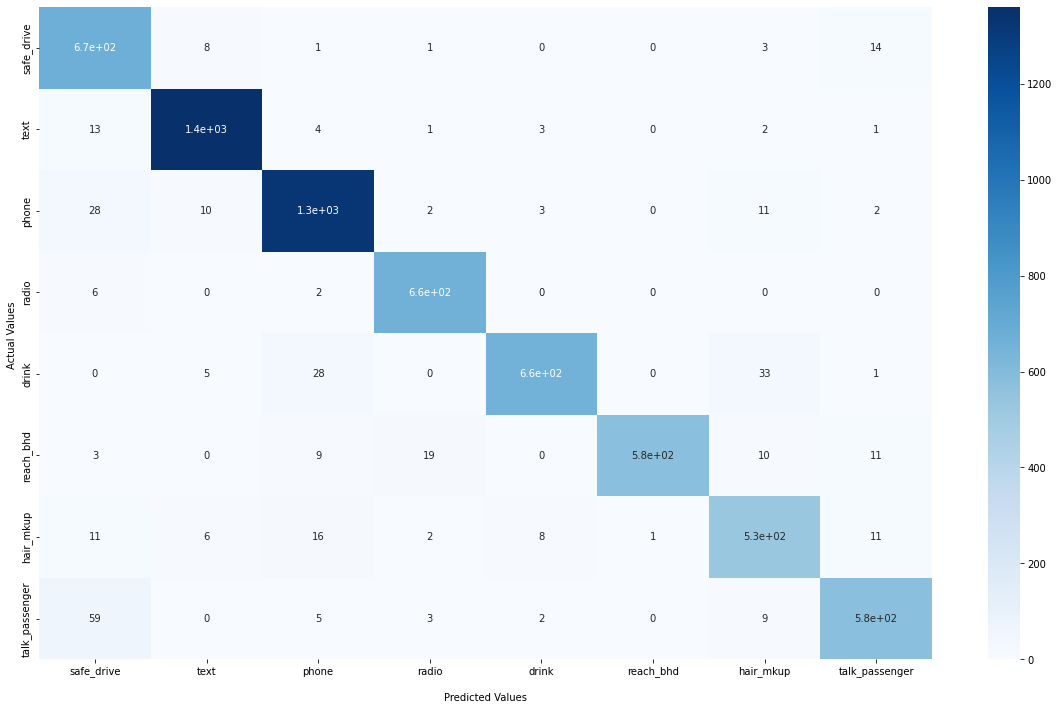

In [13]:
predictions = np.argmax(model.predict(val_ds), axis=1)
labels = np.concatenate([y for x, y in val_ds], axis=0)
confusMatrx = tf.math.confusion_matrix(labels, predictions)
print(confusMatrx)

import seaborn as sns
plt.figure(figsize=(20, 12))
ax = sns.heatmap(confusMatrx, annot=True, cmap='Blues')

ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['safe_drive', 'text', 'phone', 'radio', 'drink', 'reach_bhd', 'hair_mkup', 'talk_passenger'])
ax.yaxis.set_ticklabels(['safe_drive', 'text', 'phone', 'radio', 'drink', 'reach_bhd', 'hair_mkup', 'talk_passenger'])

plt.show()

In [18]:
y_pred = predictions
y_test = labels
from sklearn.metrics import classification_report,accuracy_score,recall_score
print("Accuracy: "+str(accuracy_score(y_test, y_pred)))
print('Recall'+str(recall_score(y_test,y_pred,average = 'macro')))
print('\n')
print(classification_report(y_test, y_pred))

Accuracy: 0.9454437342054408
Recall0.9378915914224069


              precision    recall  f1-score   support

           0       0.85      0.96      0.90       698
           1       0.98      0.98      0.98      1384
           2       0.95      0.96      0.96      1383
           3       0.96      0.99      0.97       669
           4       0.98      0.91      0.94       724
           5       1.00      0.92      0.96       631
           6       0.89      0.91      0.90       584
           7       0.94      0.88      0.91       654

    accuracy                           0.95      6727
   macro avg       0.94      0.94      0.94      6727
weighted avg       0.95      0.95      0.95      6727

